# A Markov chain monte carlo example

In the lecures we saw how to calculate a posterior distribution using Bayes' theorem. Remember, that for a continuous parameter $\theta$, 

$$
p(\theta|X) = \frac{p(X|\theta)p(\theta)}{p(X)}
$$

where $X$ represents our data, $p(\theta)$ is the *prior* probabillity of $\theta$, and $p(X)=\int p(\theta|X)d\theta$. 

To make statistical statements about the parameter $\theta$, we need to know the posterior probabity distribution $p(\theta|X)$. It is often the case (when the dataset is large or the probability model complex) that rather than calculate the posterior directly, we use monte carlo simulations to extract properties of the posterior distribution. 

In [1]:
#%matplotlib notebook

import numpy
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})

Let's take a simple example where $X\sim \phi(\theta,1)$ - is normally distributed and $p(\theta)=phi(0.5,2)$. Suppose our data is represented by a single measurement of $X=1.2$.

Our prior is now 

$$
p(\theta)\propto e^{-\frac{1}{2}\frac{(\theta-0.5)^{2}}{2^{2}}}
$$

and the *likelihood*  is, 

$$
p(X|\theta)\propto e^{-\frac{1}{2}\frac{(1.2-\theta)^{2}}{1^{2}}}
$$

where we've ignored  the normalisation terms. 

We can quickly calculate the posterior probability using the `scipy.stats.norm.pdf` method (which yields the probability density of a normal distribution) and since we need to integrate, we'll use the numerical integration `scipy.integrate`.

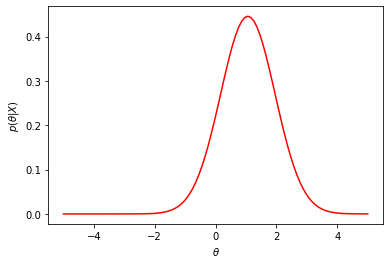

In [2]:
from scipy import stats
import scipy.integrate as integrate

xmeas = 1.2

def prior(th): 
    return stats.norm.pdf(th,0.5,2)

def likelihood(th):
    return stats.norm.pdf(xmeas,th,1)

def posterior(th):
    return likelihood(th)*prior(th)

pX = integrate.quad(posterior,-8,8)[0]

thvals = numpy.linspace(-5,5,100)
post   = [posterior(th)/pX for th in thvals]
plt.plot(thvals,post,color='red')
plt.xlabel("$\\theta$")
plt.ylabel("$p(\\theta|X)$")

plt.show()

## A basic MC approach

We can see that (as expected) the posterior is centered around our measured value of $X=1.2$. 

We could obtain the same distribution using monte carlo simulation as follows: 

   * First we randomly pick values of $\theta\rightarrow \theta'$, according to our prior $p(\theta)$. 
   * Decide whether to keep the value generated according to the likelihood. 
       * Generate a uniform random value $r\sim U(0,1)$
       * Keep the generated value of $\theta$ if $r<p(X|\theta\prime)$ 

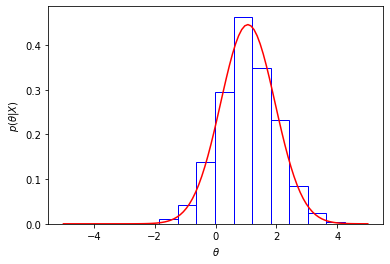

In [3]:
mcprior = numpy.random.normal(0.5,2,10000)

# I'm using a for loop in python! It's ok because it makes the steps easy to read
accepted_mc = []
for mcp in mcprior :
    rnd = numpy.random.uniform(0,1)
    plike = likelihood(mcp)
    if rnd < plike: accepted_mc.append(mcp)

plt.hist(accepted_mc,density=True,fill=False,edgecolor='blue')
plt.plot(thvals,post,color='red')
plt.xlabel("$\\theta$")
plt.ylabel("$p(\\theta|X)$")
plt.show()

The resulting distribution of values which are kept approximates the posterior distribution, as can be seen by the fact that the red line (the posterior distribution we calcuated before) matches the histogram. 

From the passing samples, we can calculate things like the mean of the posterior, or quantile ranges, that can be used for making statements about $\theta$. 

Note however, that although we generated 10,000 samples,  the number of entries  in the histogram is much less due to the acceptance step. In fact, the efficiency of the acceptance is quite low.

In [4]:
print("fraction of accepted samples",  float(len(accepted_mc))/len(mcprior))

fraction of accepted samples 0.1721


This would be very inefficient for large dimensional data spaces or more complicated likelihoods. Thankfully we can improve things using a  markov chain approach..

## A Markov chain approach and Metropolis-Hastings


a MCMC is any MC proccess where each step is dependent on the current position. 

In our simple MC, each step was completely independent of one another (the random values of $\theta$ were independent). 

proposal based on posterior but no need to normalise since it cancels in the ratio. 

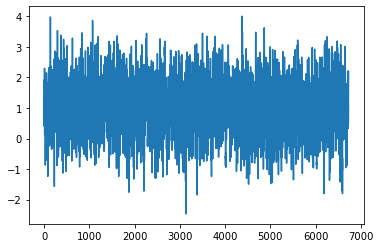

In [5]:
# define our proposal generator
# a common choice is a Gaussian centered at the current value of theta
def proposal(th):
    return numpy.random.normal(th,1)

# function to accept new proposal or reject it 
def accept_or_reject(th_new,th):  
    r = posterior(th_new)/posterior(th)
    if r > 1: 
        return th_new,True 
    else:
        alpha = min([r,1])
        rnd = numpy.random.uniform(0,1)
        if rnd < alpha : 
            return th_new,True
        else: return th,False

init_th = proposal(3)
accepted_mc_MH = []

number_steps = 10000
for i in range(number_steps) :
    
    th_new = proposal(init_th)
    th_new,accept = accept_or_reject(th_new,init_th)
    init_th = th_new
    if accept: accepted_mc_MH.append(th_new)
        
# plot the accepted points vs the step
plt.plot(range(len(accepted_mc_MH)),accepted_mc_MH)

Its usually a good idea to remove some first chunk of the markov chain since the initial part will depend on the initial value and the proposal function, meaning the distribution of the samples changes as the process continues. This is known as the *burn-in* period. We can just throw away the first 1000 points to remove this part. 

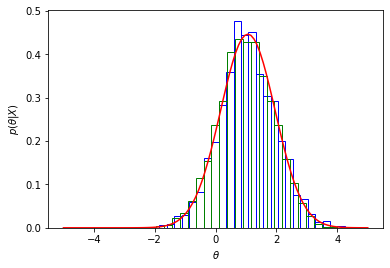

In [6]:
accepted_mc_MH = accepted_mc_MH[1000:-1]

plt.hist(accepted_mc,density=True,fill=False,edgecolor='blue',bins=25)
plt.hist(accepted_mc_MH,density=True,fill=False,edgecolor='green',bins=25)
plt.plot(thvals,post,color='red')
plt.xlabel("$\\theta$")
plt.ylabel("$p(\\theta|X)$")
plt.show()

Note again that the resulting distribution resembles the direct calculation. However this time, we have many more samples in the distribution since the generation is more efficient. 

In [7]:
print("fraction of accepted samples - simple MC",  float(len(accepted_mc))/len(mcprior))
print("fraction of accepted samples - MC MH",  float(len(accepted_mc_MH))/number_steps)

fraction of accepted samples - simple MC 0.1721
fraction of accepted samples - MC MH 0.5728


Of course, there are several packages out there that will perform markov chain mc for us based in `python`, `R`, or `c++` (eg see `pymc`, `MarkovChainMC` in `RooFit`...)